In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras import initializers

Using TensorFlow backend.


In [2]:
# the training data comes from a 
pend_data = np.load('L63_dat.npy')

d_train=pend_data[0:10000,:,:]
d_test=pend_data[9999:-1,:,:]

In [3]:
d_train=np.reshape(d_train, (800000, 50, 3))
np.shape(d_train)

(800000, 50, 3)

In [4]:
#d_train=d_train[:,:,0,:]
timesteps=np.shape(d_train)[1]

In [5]:
# this is the size of our encoded representations i.e. the width of the layers
encoding_dim = 80

# this is our input placeholder for the initial condition
input_dat = Input(shape=(3,))

# and we need another fifty placeholders for the trajectory
traject = []
for i in range(timesteps-1):
    traject.append(Input(shape=(3,)))
    
# prepares the input list
combined_in = traject
combined_in.insert(0, input_dat)

# gives weights to l2 regularization
regularizer_weight = 1e-13

# initialization of weights following Lusch
a=1/np.sqrt(encoding_dim)
init= initializers.TruncatedNormal(mean=0.0, stddev=a/2, seed=None)

# "encoded" is the encoded representation of the input, and we add hidden layers
HL_en1 = Dense(encoding_dim, 
                activation='relu',
                kernel_regularizer=regularizers.l2(regularizer_weight),
                #kernel_initializer=initializers.TruncatedNormal(mean=0.0, stddev=1/2.8, seed=None),
                bias_initializer='zeros',
                use_bias=True)

HL_en2 = Dense(encoding_dim, 
                activation='relu',
                kernel_regularizer=regularizers.l2(regularizer_weight),
                #kernel_initializer=init,
                bias_initializer='zeros',
                use_bias=True)

encoded = Dense(encoding_dim, 
                activation='linear',
                kernel_regularizer=regularizers.l2(regularizer_weight),
                #kernel_initializer=init,
                bias_initializer='zeros',
                use_bias=True)

# the koopman operator is supposed to just be a matrix, so biases are disabled
koopman = Dense(encoding_dim,
                activation='linear',
                kernel_regularizer=regularizers.l2(regularizer_weight),
                #kernel_initializer=init,
                use_bias=False)

# add hidden layers for decoding
HL_de1 = Dense(encoding_dim, 
              activation='relu',
              kernel_regularizer=regularizers.l2(regularizer_weight),
              #kernel_initializer=init,
              bias_initializer='zeros',
              use_bias=True)

HL_de2 = Dense(encoding_dim, 
              activation='relu',
              kernel_regularizer=regularizers.l2(regularizer_weight),
              #kernel_initializer=init,
              bias_initializer='zeros',
              use_bias=True)

# "decoded" is the reconstruction of the input
decoded = Dense(3,
                activation='linear',
                kernel_regularizer=regularizers.l2(regularizer_weight),
                use_bias=True)

In [6]:
np.shape(combined_in)

(50,)

In [7]:
# calculates the 1st, 2nd, ..., nth application of the Koopman layer (koopman^i(encoded))
# this corresponds to the arguments of L_pred in Lusch, 2018

K_ton=[encoded(HL_en2(HL_en1(input_dat)))]
for i in range(timesteps-1):
    K_ton.append(koopman(K_ton[-1]))
    
# remove the first element which is just decoded(encoded(input))
K_ton.pop(0)

# decodes these data points to compare with actual trajectory
DK_ton=[]
for e in K_ton:
    DK_ton.append(decoded(HL_de2(HL_de1(e))))

In [8]:
# we need an output list of the same dimension as inputs for the autoencoder to train
# the outputs include the initial condition encoded and decoded, as well as the outcome of 
# up to fifty applications of the koopman operator
combined_out=DK_ton
if len(combined_out)==timesteps-1:
    combined_out.insert(0,decoded(HL_de2(HL_de1(encoded(HL_en2(HL_en1(input_dat)))))))
len(combined_out)

50

In [9]:
# this model maps a trajectory to its projection based on the initial condition
autoencoder = Model(inputs=combined_in, outputs=combined_out  )

In [10]:
# to compile, prepare the weights given to different loss terms, 
# these are 1 for L_recon, 1/50 for each term in L_pred
weights=[0.02]*(timesteps-1)
weights.insert(0, 1)

# now we compile with this list of weights
autoencoder.compile(optimizer='adagrad', loss='mse', loss_weights=weights)

In [11]:
# before training, massage the data format a bit, as the model expects a list with 51
# arrays of dimension (trajectory_number, 2) each
t=d_train.transpose((1,0,2))
d=list(t)

In [12]:
autoencoder.fit(d,
                d,
                epochs=50,
                batch_size=128,
                shuffle=False,
                validation_split=0.5)

Train on 400000 samples, validate on 400000 samples
Epoch 1/50
400000/400000 [==============================] - 79s 197us/step - loss: 241.0119 - dense_7_loss: 2307.2439 - val_loss: 14.7205 - val_dense_7_loss: 37.7793
Epoch 2/50
400000/400000 [==============================] - 74s 185us/step - loss: 11.5739 - dense_7_loss: 32.9901 - val_loss: 9.4293 - val_dense_7_loss: 29.3032
Epoch 3/50
400000/400000 [==============================] - 74s 184us/step - loss: 8.3099 - dense_7_loss: 26.8370 - val_loss: 7.5791 - val_dense_7_loss: 24.5384
Epoch 4/50
400000/400000 [==============================] - 74s 184us/step - loss: 6.6806 - dense_7_loss: 22.2059 - val_loss: 6.1472 - val_dense_7_loss: 20.4178
Epoch 5/50
400000/400000 [==============================] - 74s 185us/step - loss: 5.6983 - dense_7_loss: 18.9736 - val_loss: 5.3704 - val_dense_7_loss: 17.8563
Epoch 6/50
400000/400000 [==============================] - 74s 185us/step - loss: 5.0660 - dense_7_loss: 16.7708 - val_loss: 4.8018 - va

In [13]:
np.shape(d_test)

(5000, 4000, 3)

In [14]:
d_test_re=np.reshape(d_test, (400000,50,3))
test=(d_test_re[0:80,:,:])
test=list(test.transpose(1,0,2))

In [25]:
p=autoencoder.predict(test)

In [26]:
p=np.array(p)
p=p.transpose(1,0,2)
one_traj=np.reshape(p, (4000, 3))

In [27]:
#plt.legend(['prediction_x1', 'prediction_x2', 'actual_x1', 'actual_x2'])
#plt.xlabel("time[steps]")
#plt.ylabel('x1: position, x2:velocity')
#print(np.array(p).transpose(1,0,2)[0,:,:])

In [28]:
np.shape(d_test)

(5000, 4000, 3)

In [29]:
real_traj=d_test[0,:,:]

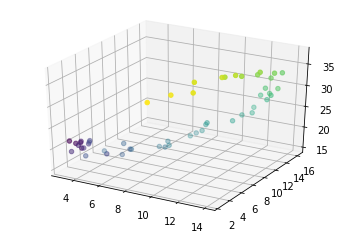

In [62]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

start=1900
stop=start+50
ax.scatter(one_traj[start:stop, 0], one_traj[start:stop, 1], one_traj[start:stop, 2], c=np.linspace(1,4000,len(one_traj[start:stop, 0])))
#ax.scatter(real_traj[start:stop,0],real_traj[start:stop,1],real_traj[start:stop,2], c=np.linspace(1,4000,len(one_traj[start:stop, 0])))
plt.draw()

In [21]:
# why the short time interval lusch et al use? 

# do decoded() and encoded() count as hidden layers in the sense that 
# lusch et al say they use two hidden layers in the encoder and decoder?

# any more elegant way than the lists I used for inputs and outputs?

# nan 

In [22]:
autoencoder.save('savemodel.h5')